/home/jfaath/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


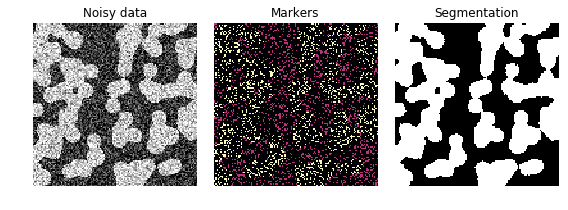

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

# Generate noisy synthetic data
data = skimage.img_as_float(binary_blobs(length=128, seed=1))
sigma = 0.35
data += np.random.normal(loc=0, scale=sigma, size=data.shape)
data = rescale_intensity(data, in_range=(-sigma, 1 + sigma),
                         out_range=(-1, 1))

# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray', interpolation='nearest')
ax1.axis('off')
ax1.set_adjustable('box-forced')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma', interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box-forced')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray', interpolation='nearest')
ax3.axis('off')
ax3.set_adjustable('box-forced')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()

(256, 256)
(array([27, 27, 27, 28]), array([153, 154, 163, 163]))
num markers: 2
(256, 256)
(256, 256)


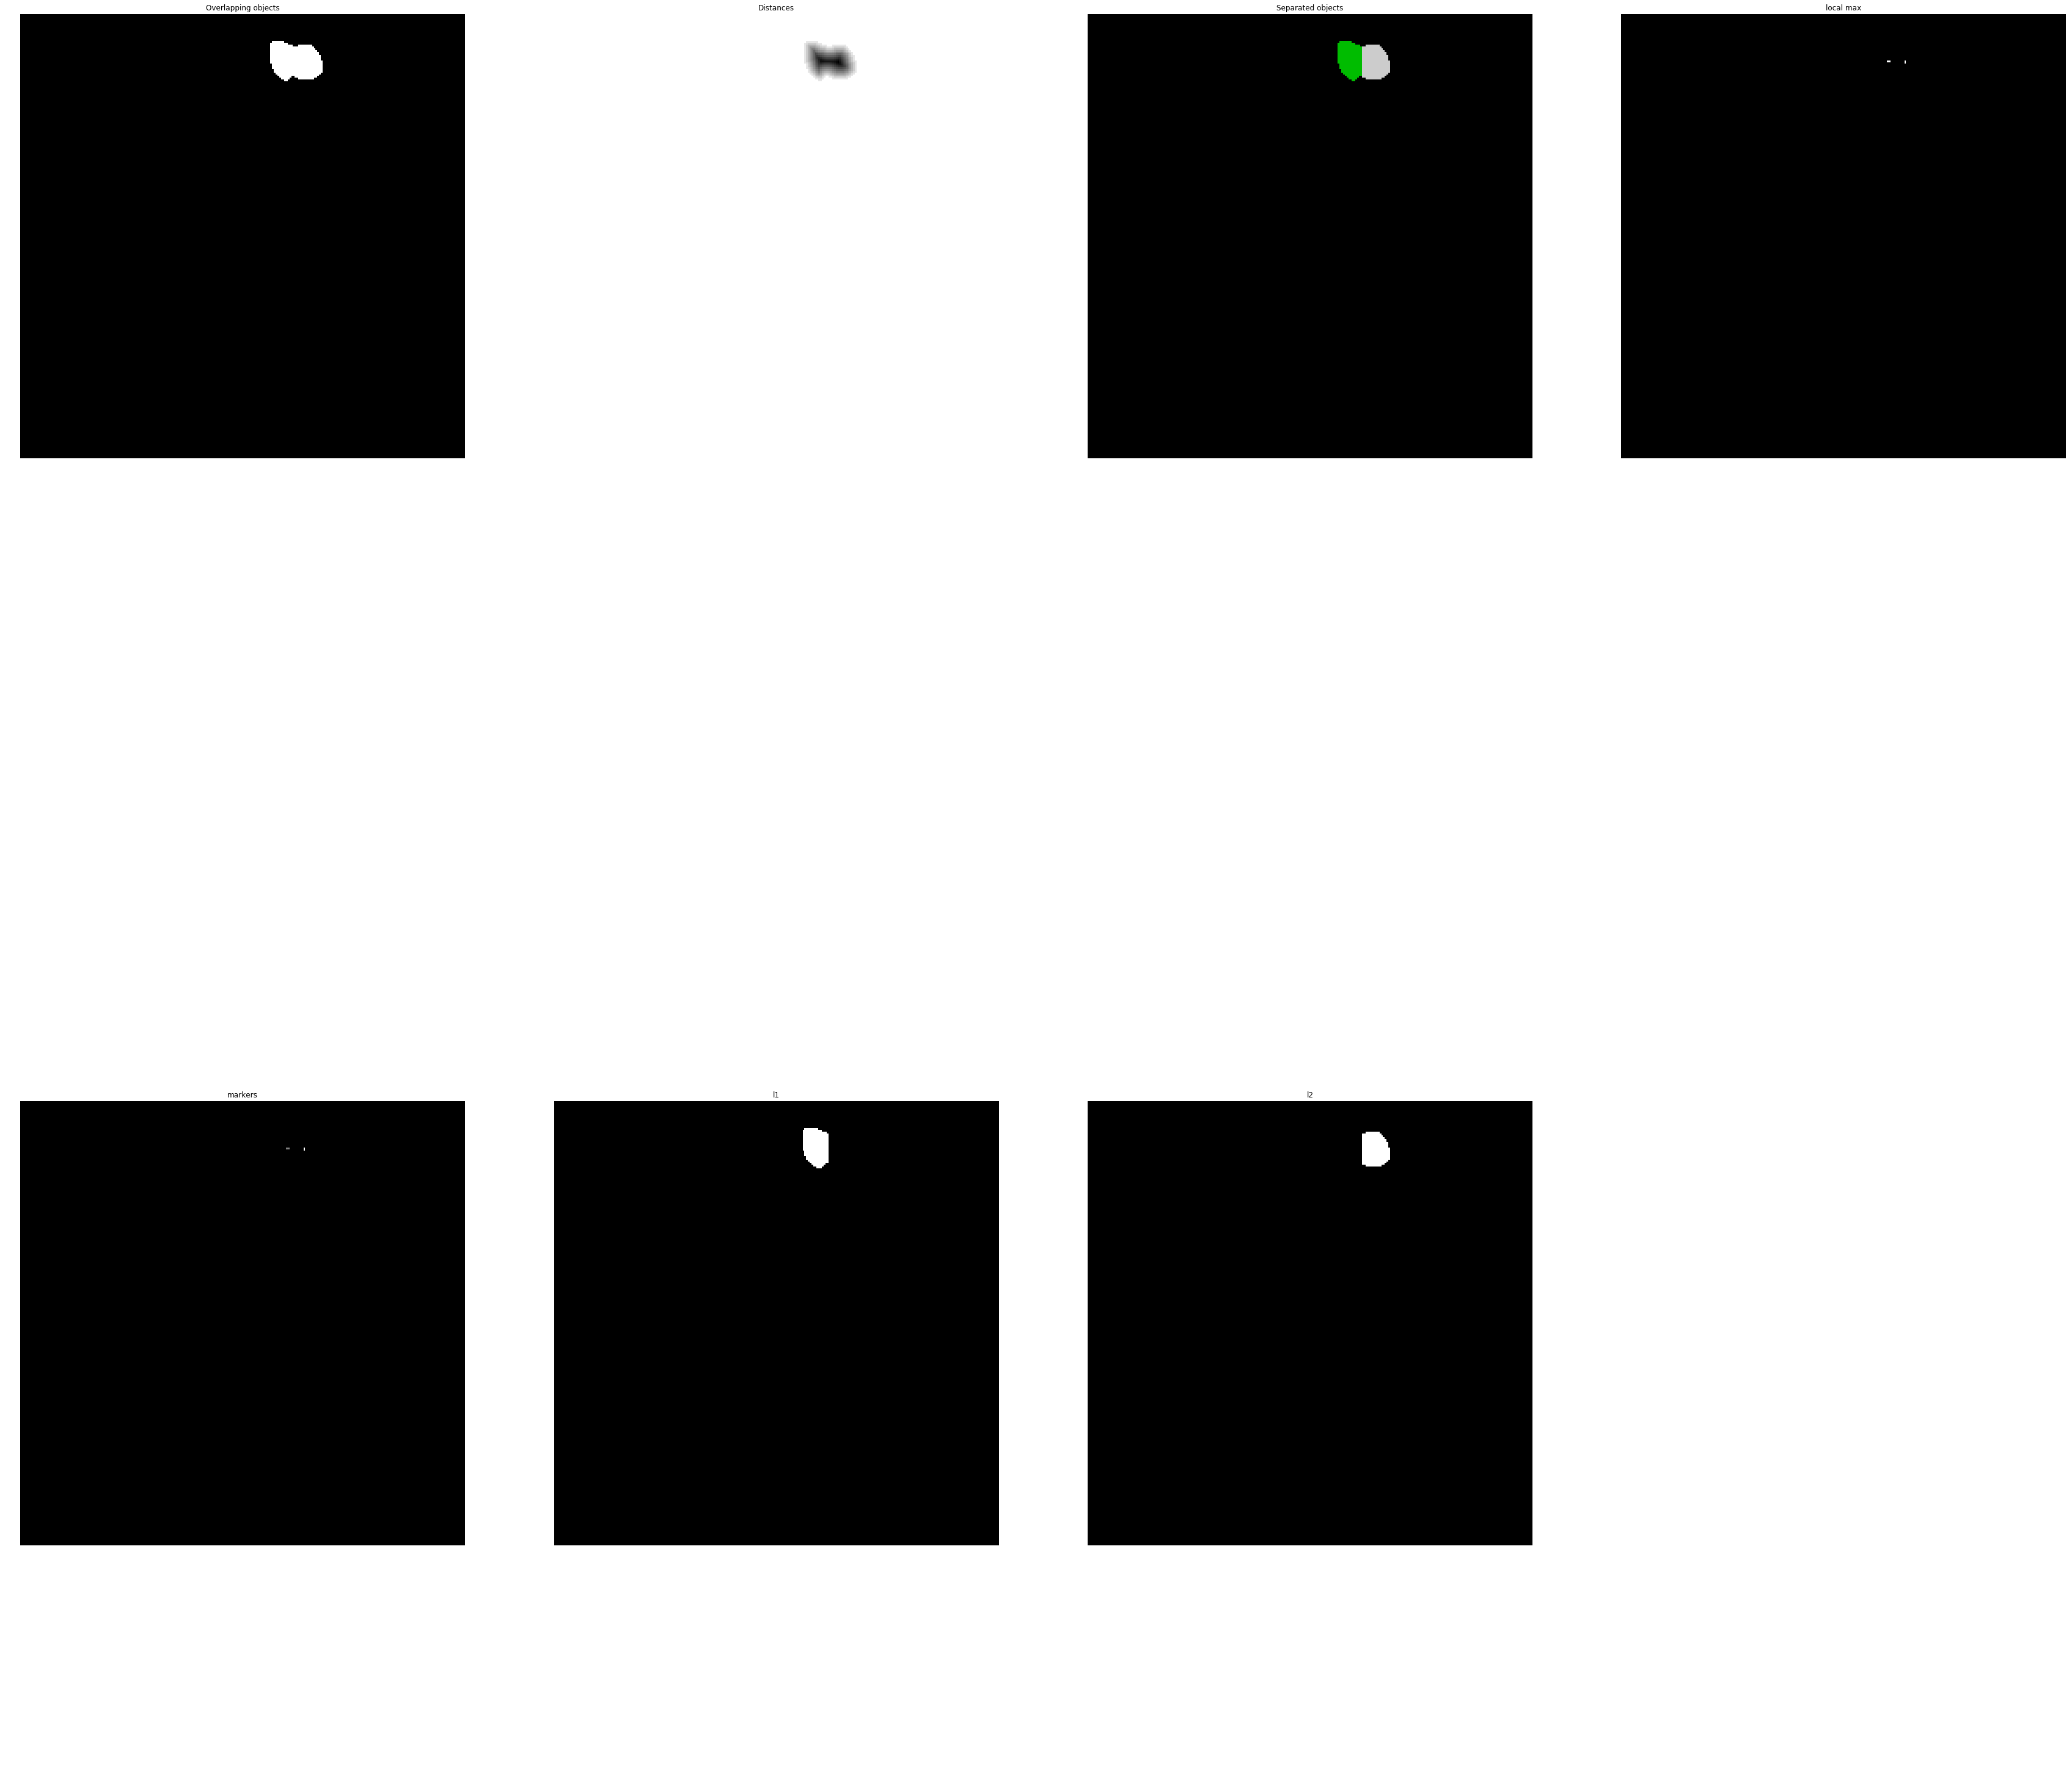

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.morphology import dilation
from PIL import Image

x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

image = Image.open('/home/jfaath/Desktop/test-images/combine-1.png')
image = np.asarray(image)

distance = ndi.distance_transform_edt(image==255)
#print(distance[25:35,25:35])
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                            labels=(image==255))
print(local_maxi.shape)
print(np.where(local_maxi==True))

marker_full = morphology.label(local_maxi)
label_res = ndi.label(local_maxi)
markers = label_res[0]
print(f"num markers: {label_res[1]}")
print(markers.shape)
labels = watershed(-distance, marker_full, mask=image)
print(labels.shape)

l1 = np.asarray(labels==1, dtype=np.uint8)
l2 = np.asarray(labels==2, dtype=np.uint8)
l1 = dilation(l1, [[1,1]])

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60, 60), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title('Separated objects')
ax[3].imshow(local_maxi, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('local max')
ax[4].imshow(markers, cmap=plt.cm.gray, interpolation='nearest')
ax[4].set_title('markers')
ax[5].imshow(l1, cmap=plt.cm.gray, interpolation='nearest')
ax[5].set_title('l1')
ax[6].imshow(l2, cmap=plt.cm.gray, interpolation='nearest')
ax[6].set_title('l2')


for a in ax:
    a.set_axis_off()

#fig.tight_layout()
plt.show()

^^^
Flow:
1. Get distance transform (distance to closest edge)
2. Get local max of the distances
3. Local max is a boolean result, running 'label' will turn it into array with labels 1,2,... at the single points of the max. These are the markers for the watershed. The 'label' method returns the number of labels.
4. Watershed will fill in the 1s, 2s etc. This needs to be separated into different masks. Use number of labels

The footprint argument in the peak_local_max method is important. If I don't have it in there or it's too small, it will produce a lot of max and therefore a lot of separations. Should adjust based on image size. (10x10) works in examples used so far, when going to 20x20, it didn't separate one. Another hyperparameter to play with I suppose.

In [8]:
from PIL import Image
from skimage import measure
import numpy as np
import glob
import os

search_path = '../raw-data/train/0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37/masks/*.png'

for file in glob.glob(search_path):
    img = Image.open(file)
    imga = np.asarray(img)
    perim = measure.perimeter(imga==255)
    print(f"{os.path.basename(file)}: {perim}")

e3600a8eb588e61c212f1aa2d188cc2c8429bb88960c956b6de828cc3ba60fd0.png: 154.66904755831212
776fadb6a090da570f8da19de3f0e8f16a1985dab01845f9587c6d59c9f41d13.png: 252.75230867899734
2689b8a661bea499e06ad3b1c42892a0fa6dc35a20d835846bf9012fc35e3a38.png: 62.04163056034261
0b04aaaabc9a184d737c91f163339d3778c970a67c862f111de1ef576874f4b7.png: 164.19595949289334
63bb16db3335a956e5489f3333174576f6cdd22eea3a267d2156895ff6ba24f5.png: 221.0538238691624
de19acbdbdeb7dad65a06c53558abca78f57961b5c943d41c0460d7b3f6c0e77.png: 146.91168824543144
d77a67f9c78c04071cfe3eaf5e78d210896412c469754f76dfeb8f9dbb3f9bb3.png: 117.698484809835
12b05b4819a6b6a4f74c8c2f8d56f762278cbc752fe6052def9e41ddb5a2b4f0.png: 158.42640687119285
54ef99aa6d7f080a1d42f7320c44bb5041b384a5be38eb46bc56ccbcb7ee8677.png: 48.72792206135786
e61869fe25ee0909053b92b9d88efd560abf86f755f3d40d6e34f85bdd9eba1f.png: 107.84062043356593
03454ab142b69a742af2e2970b8230cfa6a677170c07de03caa418d2798f3fc4.png: 213.92388155425118
c1d21ad8386731301ae340ff22

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 255 255 255 255 255 255 255]
 [  0   0   0   0 255 255 255 255 255 255 255 255 255]
 [  0   0   0 255 255 255 255 255 255 255 255 255 255]
 [  0   0   0 255 255 255 255 255 255 255 255 255 255]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255   0   0   0   0   0   0   0]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255 25

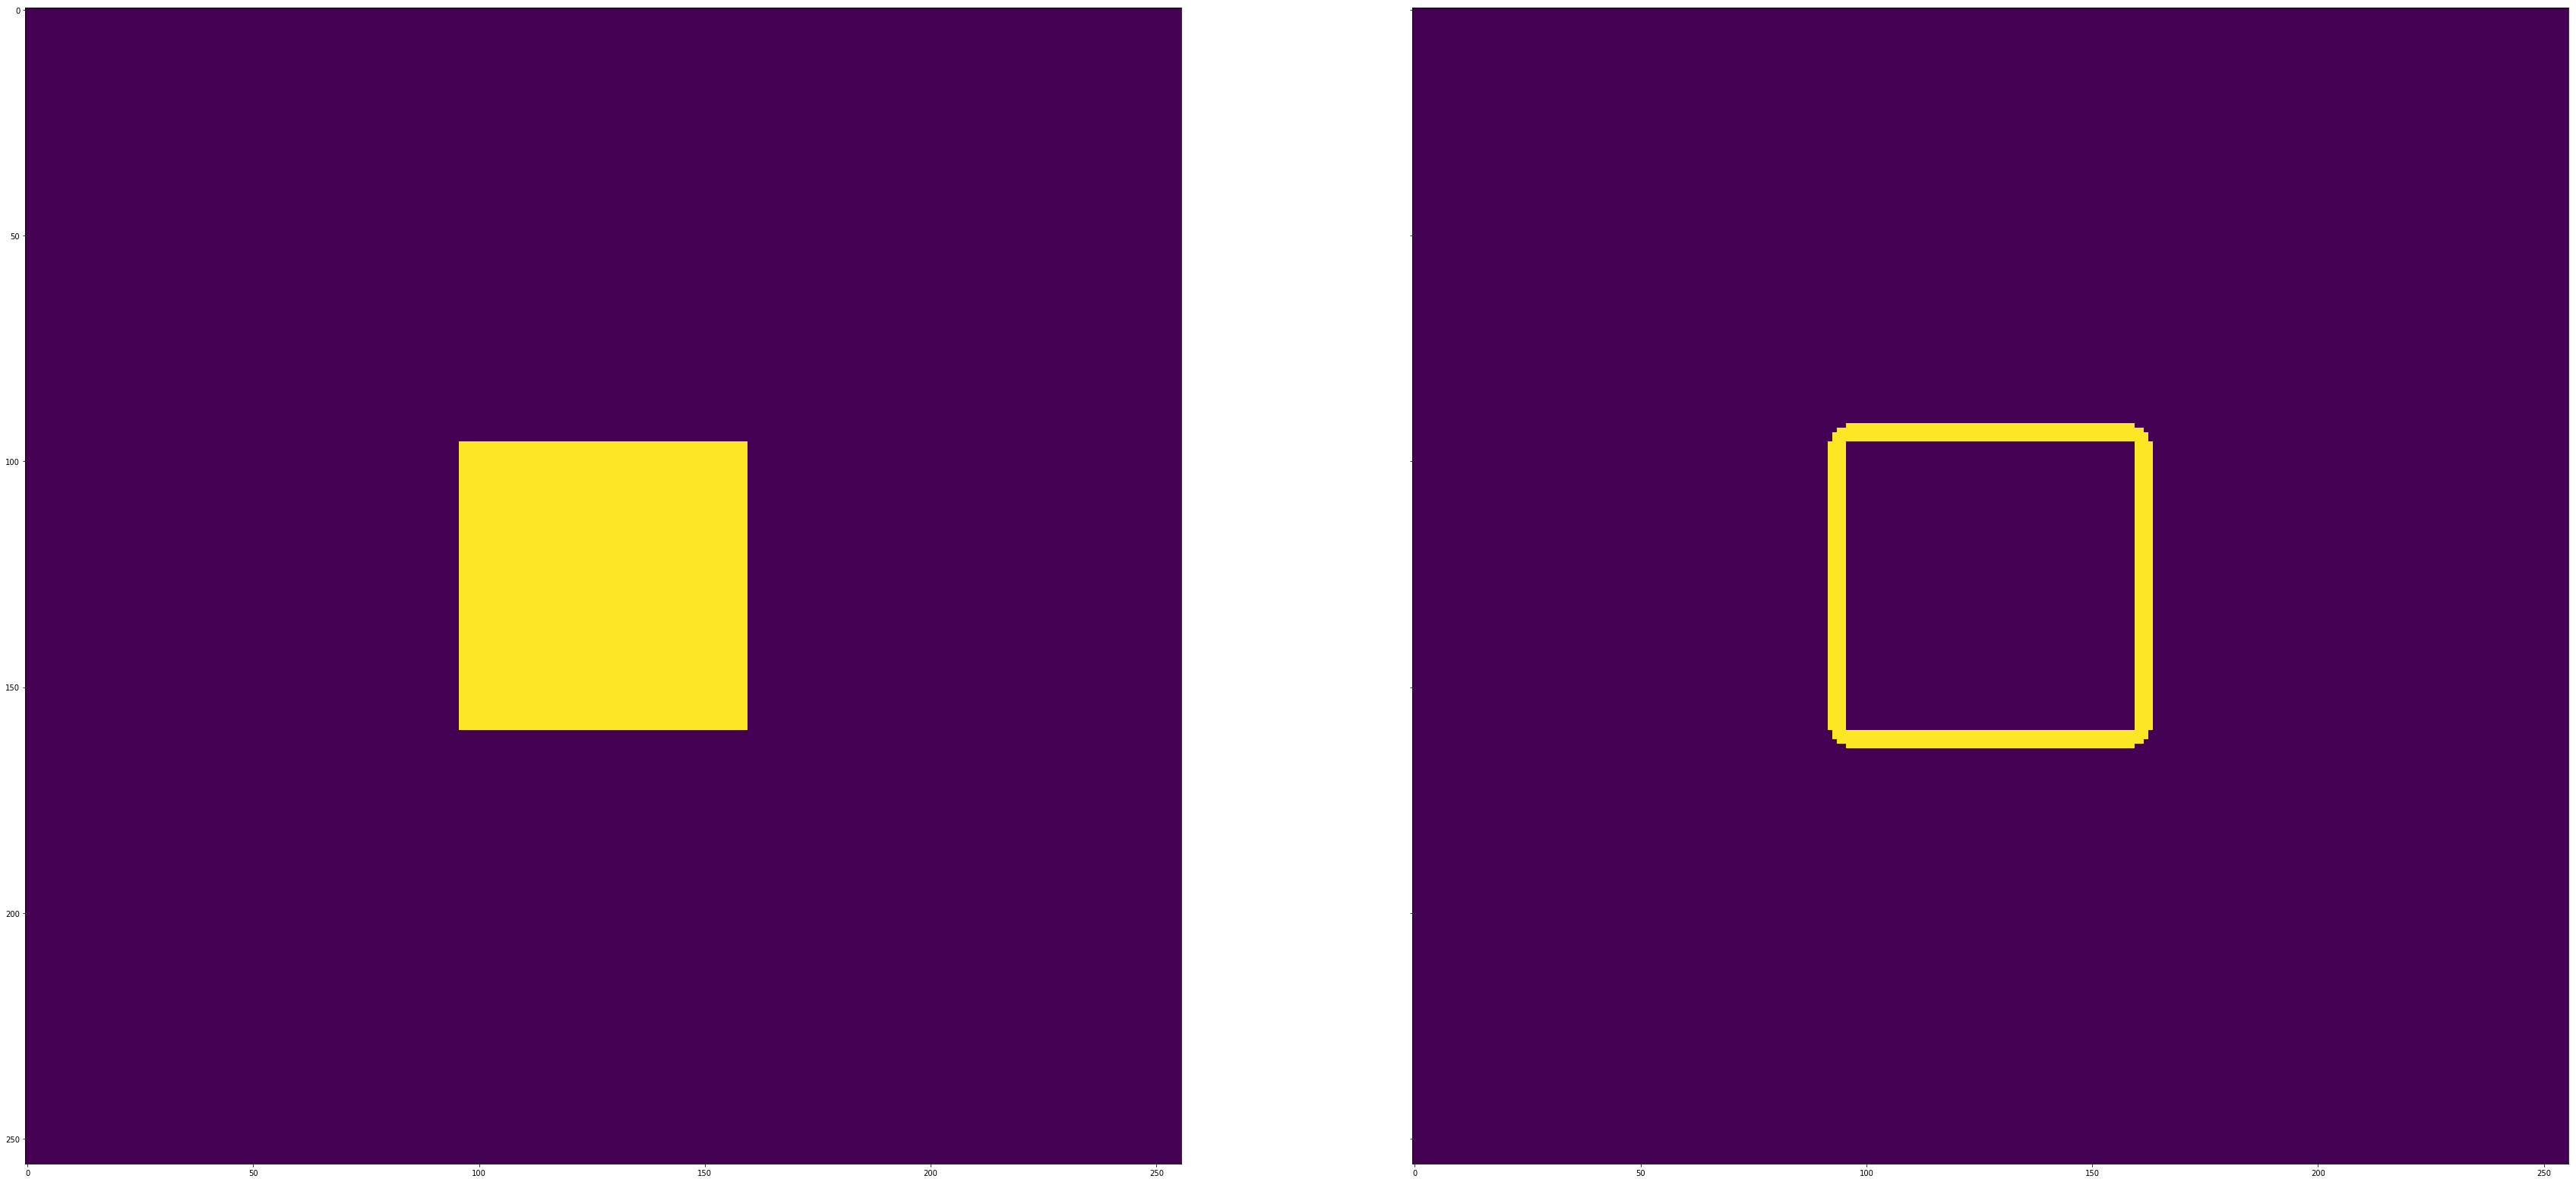

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage import morphology
from PIL import Image

x = np.zeros((256,256), dtype=np.uint8)
x[96:160, 96:160] = 255

c = np.zeros((256,256), dtype=np.uint8)
contours = measure.find_contours(x, 0.5)
for contour in contours:
    contour = contour.astype(int)
    c[contour[:, 0], contour[:, 1]] = 255

sq = morphology.disk(4)
xd = morphology.dilation(x, sq)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 60), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(x)
ax[1].imshow(xd - x)

print((xd - x)[90:103,90:103])

src = '../model-data/train/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9-con.png'
imga = np.asarray(Image.open(src), dtype=np.uint8)
print(imga[105:125,5:20])


574.27416998
2


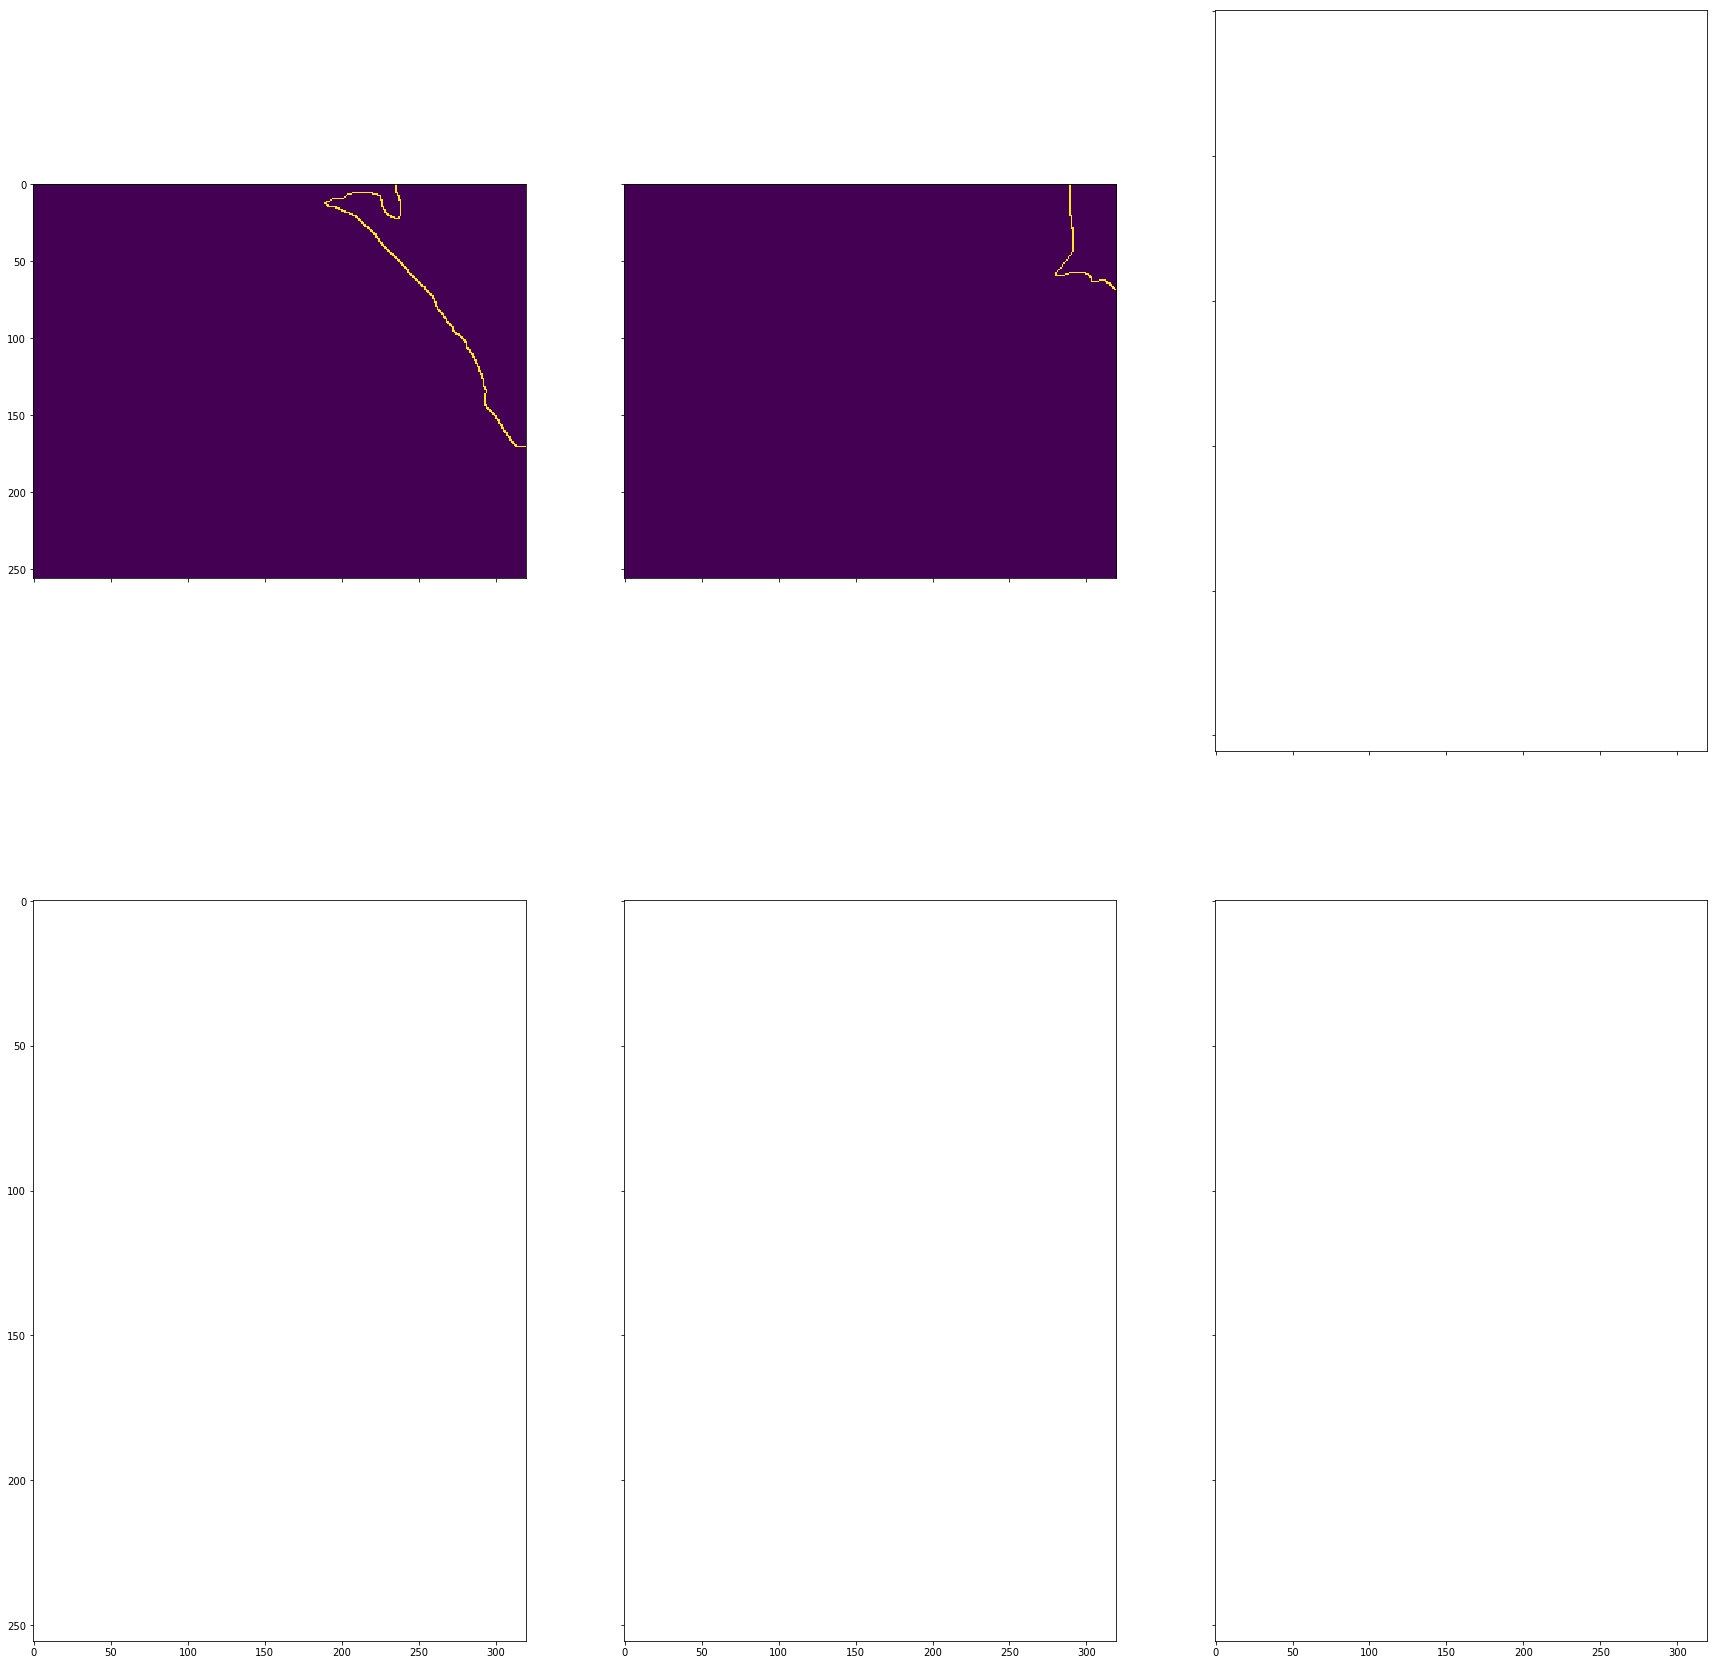

In [48]:
img = Image.open('/home/jfaath/Desktop/test_images/mcon5.png')
imga = np.asarray(img)

print(measure.perimeter(imga==255))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 30), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

contours = measure.find_contours(imga, 0.5)
print(len(contours))
for i, contour in enumerate(contours):
    c = np.zeros(imga.shape, dtype=np.uint8)
    contour = contour.astype(int)
    c[contour[:, 0], contour[:, 1]] = 255
    ax[i].imshow(c)

In [56]:
import sys
sys.path.append('../')
import os
import data

src_dir = os.path.join('..', 'raw-data', 'original', '*', 'masks')
flist = data.file_list(src_dir)

multi_con = []
for cnt, f in enumerate(flist):
    img = Image.open(f)
    imga = np.asarray(img)
    contours = measure.find_contours(imga, 0.5)
    if len(contours) > 1:
        multi_con.append(f)
        #name, ext = os.path.basename(f).split('.')
        #shutil.copy2(f, os.path.join('/home/jfaath/Desktop/con', f"{cnt}-{name}.{ext}"))
        
print(len(multi_con))
print(cnt)

69
26408


In [2]:
from skimage.morphology import closing
from skimage.morphology import disk
import shutil

d = disk(3)
for i, f in enumerate(multi_con):
    imga = np.asarray(Image.open(f))
    imgac = closing(imga, d)
    name, ext = os.path.splitext(os.path.basename(f))
    path = os.path.dirname(f)
    shutil.move(f, os.path.join('/home/jfaath/Desktop/unclose', f"{name}.png"))
    Image.fromarray(imgac).save(os.path.join(path, f"{name}-c{i}.png"))

print(f"Finished")

NameError: name 'multi_con' is not defined

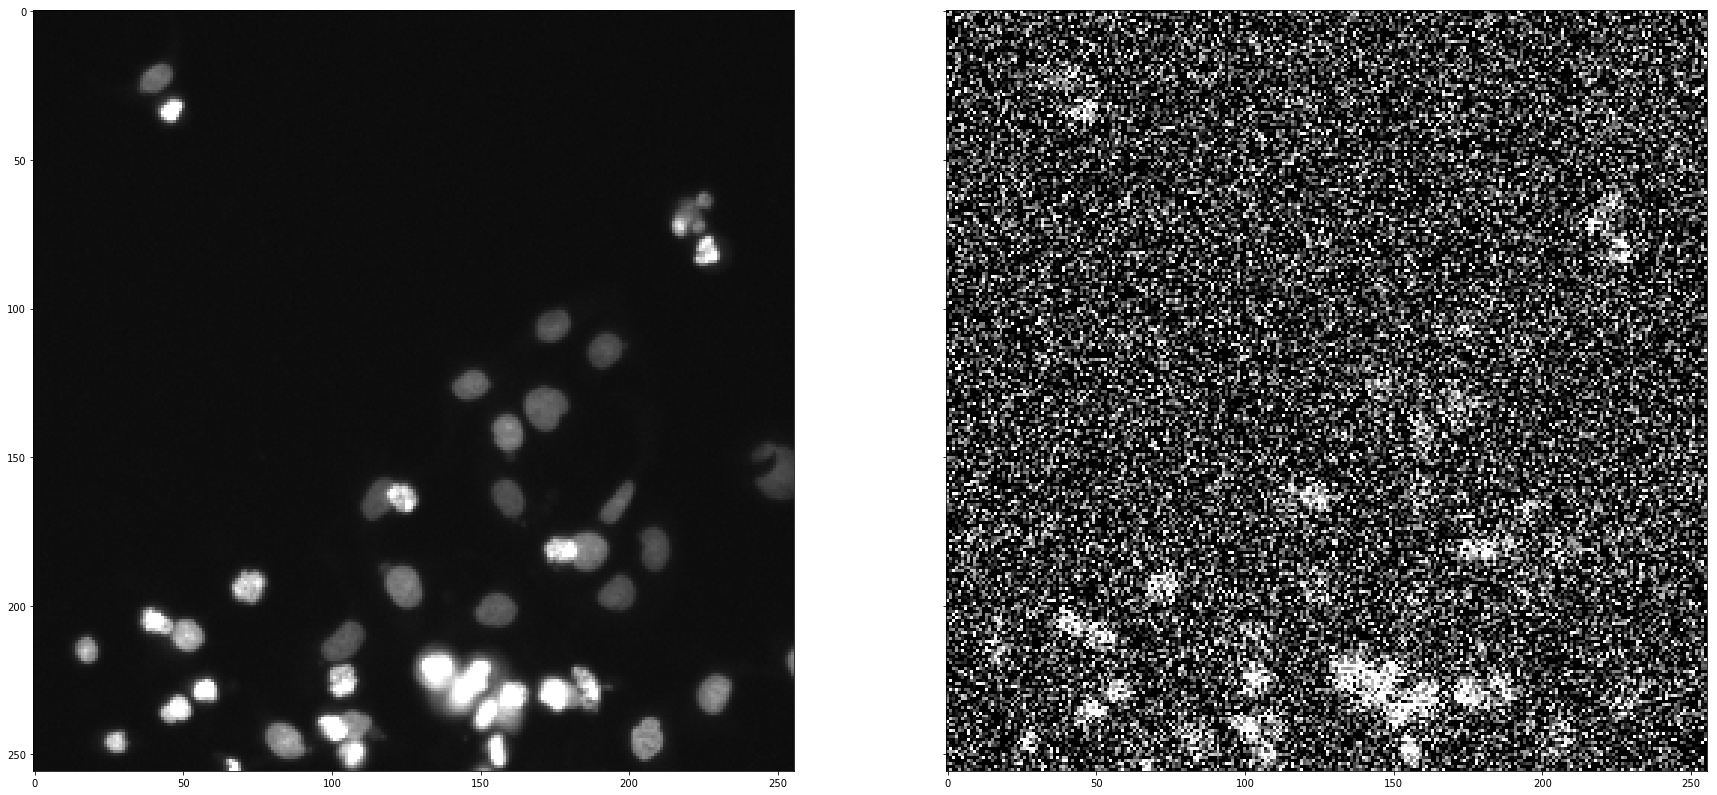

In [90]:
%matplotlib inline
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 30), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

img = Image.open('/home/jfaath/Desktop/test-images/test7.png')
imga = np.asarray(img)[:,:,:3]

ax[0].imshow(imga)

# seq = iaa.Sequential([
#     # Color
#     iaa.OneOf([
#         iaa.Sequential([
#             iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
#             iaa.WithChannels(0, iaa.Add((0, 100))),
#             iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
#         iaa.Sequential([
#             iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
#             iaa.WithChannels(1, iaa.Add((0, 100))),
#             iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
#         iaa.Sequential([
#             iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
#             iaa.WithChannels(2, iaa.Add((0, 100))),
#             iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")]),
#         iaa.WithChannels(0, iaa.Add((0, 100))),
#         iaa.WithChannels(1, iaa.Add((0, 100))),
#         iaa.WithChannels(2, iaa.Add((0, 100)))
#     ])
# ], random_order=True)

# See http://imgaug.readthedocs.io/en/latest/source/examples_basics.html
# and http://imgaug.readthedocs.io/en/latest/source/augmenters.html
# seq = iaa.ContrastNormalization(1.1)
# seq = iaa.AdditiveGaussianNoise(scale=0.025*255, per_channel=0.0)
# seq = iaa.GaussianBlur(sigma=1.0)
#seq = iaa.Multiply(1.2)

seq = iaa.Sometimes(1.0,
                    iaa.OneOf([
                        iaa.AdditiveGaussianNoise(scale=0.5*255),
                        iaa.GaussianBlur(sigma=(0, 1.0)),
                        iaa.ContrastNormalization((0.9, 1.1)),
                        iaa.Multiply((0.8, 1.2))
                    ]))


imgaug = seq.augment_image(imga)
ax[1].imshow(imgaug)